# Part 1: Import packages

In [7]:
import os
os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from copy import deepcopy
from scipy.stats import norm
from sklearn.model_selection import KFold
import warnings # warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

In [ ]:
# PLEASE MAKE SURE THE PACKAGE VERSIONS MATCH THOSE IN THE README
import sys
import scipy
import sklearn
import joblib

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)

# Part 2: Define functions and estimators

In [8]:
def cdid_panel(Y1, Y0, D, nD, X, d, v, h, B, estimators):
    """
    Estimate the Average Treatment Effect on the Treated (ATT) using repeated outcomes (panel) methods 
    and implement multiplier bootstrap for standard errors.

    Parameters:
    Y1 (array-like): Outcome post-treatment.
    Y0 (array-like): Outcome pre-treatment.
    D (array-like): Treatment variable (D=0 for control, D=d for treated).
    nD (array-like): Indicator for the control group (1 if D=0, 0 otherwise).
    X (pd.DataFrame or array-like): Covariates.
    d (float): Specific treatment intensity to learn the ATT for.
    v (int): Number of folds for cross-fitting.
    h (float): Undersmooth kernel bandwidth, e.g., np.around(n**(-1/4)).
    B (int): Number of bootstrap samples.
    estimators (dict): Dictionary specifying estimators for 'propensity', 'outcome', and 'condens'.

    Returns:
    tuple: (Mean ATT, Mean variance, List of bootstrap ATTs)
    """

    # Initialize cross-validation
    kf = KFold(n_splits=v, shuffle=True, random_state=923)
    epsilon = 1e-6

#    # Define kernel function (Epanechnikov kernel)
#    def K(h, x, d):
#        u = (x - d) / h
#        return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2) / h, 0)

    # Define Gaussian kernel function
    
    def K(h, x, d):
        return norm.pdf((x - d) / h) / h

    # Create cross-validation splits
    xs = [(train_index, test_index) for train_index, test_index in kf.split(X)]
    
    # Generate Gaussian multipliers for bootstrap
    mp = [np.random.normal(1, 1, len(Y1)) for _ in range(B)]

    # Function to compute ATT and variance for each fold
    def compute_fold(train_index, test_index):
        trainX, testX = X.iloc[train_index], X.iloc[test_index]
        trainD, testD = D[train_index], D[test_index]
        trainY1, testY1 = Y1[train_index], Y1[test_index]
        trainY0, testY0 = Y0[train_index], Y0[test_index]
        trainnD, testnD = nD[train_index], nD[test_index]

        # Kernel regression model
        condens_estimator = deepcopy(estimators['condens']).fit(trainX, K(h, trainD, d))
        fh = lambda x: deepcopy(condens_estimator).predict(x)

        # Step 1: Estimation of nuisance parameters
        yl = trainY1 - trainY0

        # Kernel density at f_D(d)
        fd = np.mean(K(h, trainD, d))

        # Propensity score P(D=0|X)
        propensity_estimator = deepcopy(estimators['propensity']).fit(trainX, trainnD)
        g = lambda x: np.clip(deepcopy(propensity_estimator).predict_proba(x)[:, 1], epsilon, 1)

        # Regression E[(Y1-Y0)|X,D]
        trainX0 = trainX.copy()
        trainX0.insert(0, 'nD', trainnD)  # Include nD variable
        outcome_estimator = deepcopy(estimators['outcome']).fit(trainX0, yl)
        E = lambda x: deepcopy(outcome_estimator).predict(x)

        # Step 2: Estimate the i-th ATT inside the cross-fitting using testing sample
        testX0 = testX.copy()
        testX0.insert(0, 'nD', 1)  # Adding a column of 1's for nD = 1{D=0}

        ylt = testY1 - testY0
        
        # Calculate orthogonal score psi
        psi = (ylt - E(testX0)) * (K(h, testD, d) * g(testX) - testnD * fh(testX)) / (fd * g(testX))

        # Calculate ATT for this fold
        theta = np.mean(psi)

        # Asymptotic variance calculation
        sig2 = (psi - (theta * K(h, testD, d)) / fd) ** 2
        VAR = np.mean(sig2)

        return theta, VAR, psi

    # Compute results for each fold and implement multiplier bootstrap
    results = Parallel(n_jobs=-1)(delayed(compute_fold)(train_index, test_index) for train_index, test_index in xs)

    att = []
    var = []
    attb = [[] for _ in range(v)]

    for i, (theta, VAR, psi) in enumerate(results):
        att.append(theta)
        var.append(VAR)
        
        # Multiplier bootstrap
        for b in range(B):
            attb[i].append(np.mean(mp[b][xs[i][1]] * psi))
    
    # Return mean ATT, mean variance, and bootstrap ATTs
    return np.mean(att), np.mean(var), [np.mean(x) for x in zip(*attb)]

In [9]:
def cdid_cross(Y, T, D, nD, X, d, v, h, B, estimators):
    """
    Estimate the Average Treatment Effect on the Treated (ATT) using repeated outcomes methods 
    and implement multiplier bootstrap for standard errors.

    Parameters:
    Y (array-like): Outcome variable.
    T (array-like): Treatment indicator (1 for treated, 0 for control).
    D (array-like): Treatment variable (D=0 for control, D=d for treated).
    nD (array-like): Indicator for the control group (1 if D=0, 0 otherwise).
    X (pd.DataFrame or array-like): Covariates.
    d (float): Specific treatment intensity to learn the ATT for.
    v (int): Number of folds for cross-fitting.
    h (float): Undersmooth kernel bandwidth, e.g., np.around(n**(-1/4)).
    B (int): Number of bootstrap samples.
    estimators (dict): Dictionary specifying estimators for 'propensity', 'outcome', and 'condens'.

    Returns:
    tuple: (Mean ATT, Mean variance, List of bootstrap ATTs)
    """

    # Initialize cross-validation
    kf = KFold(n_splits=v, shuffle=True, random_state=923)
    epsilon = 1e-6

#     # Define kernel function (Epanechnikov kernel)
#     def K(h, x, d):
#         u = (x - d) / h
#         return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2) / h, 0)
    
    # Define Gaussian kernel function
    def K(h, x, d):
        return norm.pdf((x - d) / h) / h

    # Create cross-validation splits
    xs = [(train_index, test_index) for train_index, test_index in kf.split(X)]
    
    # Generate Gaussian multipliers for bootstrap
    mp = [np.random.normal(1, 1, len(Y)) for _ in range(B)]

    # Function to compute ATT and variance for each fold
    def compute_fold(train_index, test_index):
        trainX, testX = X.iloc[train_index], X.iloc[test_index]
        trainD, testD = D[train_index], D[test_index]
        trainY, testY = Y[train_index], Y[test_index]
        trainT, testT = T[train_index], T[test_index]
        trainnD, testnD = nD[train_index], nD[test_index]

        # Kernel regression model
        condens_estimator = deepcopy(estimators['condens']).fit(trainX, K(h, trainD, d))
        fh = lambda x: deepcopy(condens_estimator).predict(x)

        # Step 1: Estimation of nuisance parameters
        lbd = np.mean(trainT)  # Proportion treated
        yl = trainY * ((trainT - lbd) / (lbd * (1 - lbd)))

        # Kernel density at f_D(d)
        fd = np.mean(K(h, trainD, d))

        # Propensity score P(D=0|X)
        propensity_estimator = deepcopy(estimators['propensity']).fit(trainX, trainnD)
        g = lambda x: np.clip(deepcopy(propensity_estimator).predict_proba(x)[:, 1], epsilon, 1)

        # Regression E[Y|X,D]
        trainX0 = trainX.copy()
        trainX0.insert(0, 'nD', trainnD)  # Include nD variable
        outcome_estimator = deepcopy(estimators['outcome']).fit(trainX0, yl)
        E = lambda x: deepcopy(outcome_estimator).predict(x)

        # Step 2: Estimate the i-th ATT inside the cross-fitting using testing sample
        testX0 = testX.copy()
        testX0.insert(0, 'nD', 1)  # Adding a column of 1's for nD = 1{D=0}

        ylt = testY * ((testT - lbd) / (lbd * (1 - lbd)))

        # Calculate orthogonal score psi
        psi = (ylt - E(testX0)) * (K(h, testD, d) * g(testX) - testnD * fh(testX)) / (fd * g(testX))

        # Calculate ATT for this fold
        theta = np.mean(psi)

        # Asymptotic variance calculation
        sig2 = (psi - (theta * K(h, testD, d)) / fd) ** 2
        VAR = np.mean(sig2)

        return theta, VAR, psi

    # Compute results for each fold and implement multiplier bootstrap
    results = Parallel(n_jobs=-1)(delayed(compute_fold)(train_index, test_index) for train_index, test_index in xs)

    att = []
    var = []
    attb = [[] for _ in range(v)]

    for i, (theta, VAR, psi) in enumerate(results):
        att.append(theta)
        var.append(VAR)
        
        # Multiplier bootstrap
        for b in range(B):
            attb[i].append(np.mean(mp[b][xs[i][1]] * psi))
    
    # Return mean ATT, mean variance, and bootstrap ATTs
    return np.mean(att), np.mean(var), [np.mean(x) for x in zip(*attb)]

# Part 3: Empirical application with simulated data

In [10]:
# Estimators used in our case
estimators = {
    'propensity':  CalibratedClassifierCV(
        estimator=RandomForestClassifier(max_depth=20, min_samples_leaf= 5, n_estimators=200, random_state=923),
        cv=5,
        n_jobs=5
    ),
    'outcome': RandomForestRegressor(max_depth=20, min_samples_leaf= 5, n_estimators=200, n_jobs = 2, random_state=923),
    'condens': RandomForestRegressor(max_depth=20, min_samples_leaf= 5, n_estimators=200, n_jobs = 2, random_state=923)
}

In [ ]:
# Panel, Capital-Labor Ratio, Average

In [59]:
# Preparing data

df_main = pd.read_csv("af_wide.csv")

# In the replication package, af_wide.csv is created using made_AF_data.do with the ppsreplicationdata_simulated.csv.
# See "Simulate empirical application data.ipynb" for details on how the simulated data care created.

# If one has access to the original Acemoglu and Finkelstein 2008 data (ppsreplicationdata.dta), the make_AF_data.do
# will create af_wide.csv using ppsreplicationdata.dta instead and the actual results in the paper will be replicated. 

# See README and make_AF_data.do in the refplication package on how to create af_wide.csv data from
#  the ppsreplicationdata.dta if one has access.


dfcl_vars = ['deprshare'+str(i) for i in range(1980,1987)]+['mcrsharee1983','bdtot1983','totms1983','private1983','msa1983']+ ['st'+str(i) for i in range(10,49)] + ['open_heart_tech1983', 'catheterization_tech1983', 'radioiso_diag_tech1983', 'radio_implants_tech1983',
   'radioiso_ther_tech1983', 'xray_ther_tech1983', 'megavolt_tech1983', 'organ_transplant_tech1983', 'ct_tech1983']

dfcl = df_main[dfcl_vars].copy()
dfcl['nD'] = 1
dfcl.loc[dfcl.mcrsharee1983 != 0, 'nD'] = 0
dfcl['y1'] = (dfcl.deprshare1984 + dfcl.deprshare1985 + dfcl.deprshare1986)/3
dfcl['y0'] = (dfcl.deprshare1980 + dfcl.deprshare1981 + dfcl.deprshare1982 + dfcl.deprshare1983)/4

dfcl_vars2 = ['y1','y0','mcrsharee1983','nD','bdtot1983','totms1983',
              'private1983','msa1983']+ ['st'+str(i) for i in range(10,49)] + ['open_heart_tech1983','catheterization_tech1983', 'radioiso_diag_tech1983', 'radio_implants_tech1983',
   'radioiso_ther_tech1983', 'xray_ther_tech1983', 'megavolt_tech1983', 'organ_transplant_tech1983', 'ct_tech1983']


dfcl = (dfcl[dfcl_vars2].copy()).dropna()
column_labels_index = {
                dfcl.columns[0]: 'Y1',
                dfcl.columns[1]: 'Y0',
                dfcl.columns[2]: 'D'
                }
dfcl.rename(columns=column_labels_index, inplace=True)

sc = StandardScaler()
sc_list = ['bdtot1983','totms1983']
X_scaled = pd.DataFrame(sc.fit_transform(dfcl.loc[:,sc_list]), columns = sc_list, index = dfcl.index)
dfcl = dfcl.drop(columns = sc_list)
dfcl = pd.concat([dfcl, X_scaled], axis = 1)


# Split variables for function input
Y1_cl = dfcl['Y1'].to_numpy()
Y0_cl = dfcl['Y0'].to_numpy()
D_cl = dfcl['D'].to_numpy()
nD_cl = dfcl['nD'].to_numpy()
X_cl = dfcl.drop(columns=['Y1', 'Y0', 'D', 'nD'])  # All remaining variables are covariates


In [60]:
## set model paramters:

# create a list of grid points

D_pos_cl = D_cl[D_cl>0]

dl_cl = np.percentile(D_pos_cl, 2.5)
du_cl = np.percentile(D_pos_cl, 97.5)

dlist = np.round(np.linspace(dl_cl,du_cl,100),3).tolist()

n = len(D_cl)

# Silverman's choice + undermoothing with n^(-1/4) instead of n^(1/5)
h = 1.06*np.std(D_cl[D_cl>0])*n**(-1/4)
v = 5 # v-fold cross fitting
B = 1000 # number of multiplier bootstraps

In [61]:
## running the model

att_cl = []
sd_cl = []
attb_cl = []

for d in dlist:
    attd, vard, attbd = cdid_panel(Y1_cl, Y0_cl, D_cl, nD_cl, X_cl, d, v, h, B, estimators)
    att_cl.append(attd)
    sd_cl.append((vard/n)**(1/2))
    attb_cl.append(attbd)

In [62]:
unif_cl = [
    max(np.abs(att_cl[i] - attb_cl[i][b])/sd_cl[i] for i in range(len(dlist)))
    for b in range(B)
]

# uncomment if want to use the pointwise bootstrap CI
#yl_cl = [att_cl[i]- np.percentile(attb_cl[i]-att_cl[i], 97.5) for i in range(len(dlist))]
#yu_cl = [att_cl[i]- np.percentile(attb_cl[i]-att_cl[i], 2.5) for i in range(len(dlist))]

yl_cl = [att_cl[i]- 1.96*sd_cl[i] for i in range(len(dlist))]
yu_cl = [att_cl[i]+ 1.96*sd_cl[i] for i in range(len(dlist))]

# uniform bootstrap CI
yl_unif_cl = [att_cl[i] - np.percentile(unif_cl, 95)*sd_cl[i] for i in range(len(dlist))]
yu_unif_cl = [att_cl[i] + np.percentile(unif_cl, 95)*sd_cl[i] for i in range(len(dlist))]


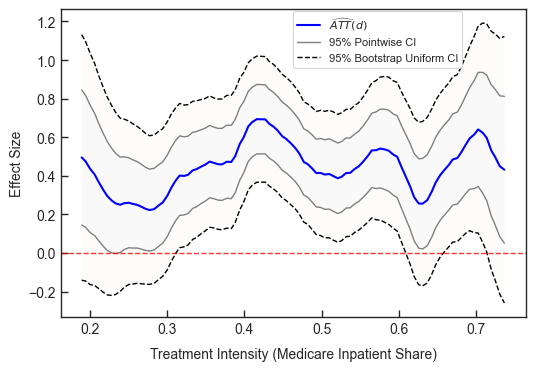

In [63]:
# NOTE: the styles are set to fit the original actual data set. 
# Adjust as needed for simulated dataset for aethetics.

# Set seaborn theme for better aesthetics
sns.set_theme()
#sns.set_theme(style="whitegrid")  # Subtle grid for readability
sns.set_context("paper")  # Paper-friendly settings
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})

# Convert lists to numpy arrays
yk_cl = np.asarray(att_cl)
yl_cl = np.asarray(yl_cl)
yu_cl = np.asarray(yu_cl)
yl_unif_cl = np.asarray(yl_unif_cl)
yu_unif_cl = np.asarray(yu_unif_cl)
xk_cl = dlist #np.linspace(dl, du, len(dlist))

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size for better proportions

# Plot lines
ax.plot(xk_cl, yk_cl, '-', color='blue', markersize=2, linewidth=1.5, label=r'$\widehat{ATT}(d)$')
ax.plot(xk_cl, yl_cl, '-', color='gray', linewidth=1, label='95% Pointwise CI')
ax.plot(xk_cl, yu_cl, '-', color='gray', linewidth=1)
ax.plot(xk_cl, yl_unif_cl, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
ax.plot(xk_cl, yu_unif_cl, '--', color='black', linewidth=1)

# Horizontal reference line at zero
ax.axhline(y=0, color='red', linewidth=1, linestyle='--', alpha=0.8)

# Add shaded confidence bands
ax.fill_between(xk_cl, yl_cl, yu_cl, alpha=0.02)  # Pointwise CI shading
ax.fill_between(xk_cl, yl_unif_cl, yu_unif_cl,alpha=0.02)  # Uniform CB shading


# Labels and title
ax.set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10, labelpad=8)
ax.set_ylabel(r'Effect Size', fontsize=10, labelpad=3)  # Add ylabel for clarity
#ax.set_title(r'ATT($d$): Capital-Labor Ratio, Panel (Average)', fontsize=12, pad=10)

# Adjust tick font size and format
ax.tick_params(axis='both', which='major', labelsize=10)

# set y-axis limit for better comparison
#ax.set_ylim(-0.7, 2.2)

# Improved legend positioning

ax.legend(fontsize=8, bbox_to_anchor=(0.5, 0.81), borderaxespad=0)


# Save as high-quality PDF (comment out if not needed)
#plt.savefig("cdid_cl_panel_avg_rnr.pdf", bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
# Panel, Tech Adoption, Average

In [70]:
df_main = pd.read_csv("af_wide.csv")

# In the replication package, af_wide.csv is created using made_AF_data.do with the ppsreplicationdata_simulated.csv.
# See "Simulate empirical application data.ipynb" for details on how the simulated data care created.

# If one has access to the original Acemoglu and Finkelstein 2008 data (ppsreplicationdata.dta), the make_AF_data.do
# will create af_wide.csv using ppsreplicationdata.dta instead and the actual results in the paper will be replicated. 

# See README and make_AF_data.do in the refplication package on how to create af_wide.csv data from
#  the ppsreplicationdata.dta if one has access.

dftech_vars = ['bintechcount'+str(i) for i in range(1980,1987)]+['mcrsharee1983','bdtot1983','totms1983','private1983','msa1983']+ ['st'+str(i) for i in range(10,49)]
dftech = df_main[dftech_vars].copy()
dftech['nD'] = 1
dftech.loc[dftech.mcrsharee1983 != 0, 'nD'] = 0
dftech['y1'] = (dftech.bintechcount1984 + dftech.bintechcount1985)/2
dftech['y0'] = (dftech.bintechcount1980 + dftech.bintechcount1981 + dftech.bintechcount1982 + dftech.bintechcount1983)/4
dftech_vars2 = ['y1','y0','mcrsharee1983','nD','bdtot1983','totms1983','private1983','msa1983']+ ['st'+str(i) for i in range(10,49)]
dftech = (dftech[dftech_vars2].copy()).dropna()
column_labels_index = {
                dftech.columns[0]: 'Y1',
                dftech.columns[1]: 'Y0',
                dftech.columns[2]: 'D'
                }
dftech.rename(columns=column_labels_index, inplace=True)

sc = StandardScaler()
sc_list = ['bdtot1983','totms1983']
X_scaled = pd.DataFrame(sc.fit_transform(dftech.loc[:,sc_list]), columns = sc_list, index = dftech.index)
dftech = dftech.drop(columns = sc_list)
dftech = pd.concat([dftech, X_scaled], axis = 1)

# Split variables for function input
Y1_tech = dftech['Y1'].to_numpy()
Y0_tech = dftech['Y0'].to_numpy()
D_tech = dftech['D'].to_numpy()
nD_tech = dftech['nD'].to_numpy()
X_tech = dftech.drop(columns=['Y1', 'Y0', 'D', 'nD'])  # All remaining variables are covariates


In [71]:
## set model paramters:

# create a list of grid points

D_pos_tech = D_tech[D_tech>0]

dl_tech = np.percentile(D_pos_tech, 2.5)
du_tech = np.percentile(D_pos_tech, 97.5)

dlist = np.round(np.linspace(dl_tech,du_tech,100),3).tolist()

n = len(D_tech)

# Silverman's choice + undermoothing with n^(-1/4) instead of n^(1/5)
h = 1.06*np.std(D_tech[D_tech > 0])*n**(-1/4)
v = 5 # v-fold cross fitting
B = 1000 # number of multiplier bootstraps

In [72]:
att_tech = []
sd_tech = []
attb_tech = []

for d in dlist:
    attd, vard, attbd = cdid_panel(Y1_tech, Y0_tech, D_tech, nD_tech, X_tech, d, v, h, B, estimators)
    att_tech.append(attd)
    sd_tech.append((vard/n)**(1/2))
    attb_tech.append(attbd)

In [73]:
unif_tech = [
    max(np.abs(att_tech[i] - attb_tech[i][b])/sd_tech[i] for i in range(len(dlist)))
    for b in range(B)
]

#yl_tech = [att_tech[i]- np.percentile(attb_tech[i]-att_tech[i], 97.5) for i in range(len(dlist))]
#yu_tech = [att_tech[i]- np.percentile(attb_tech[i]-att_tech[i], 2.5) for i in range(len(dlist))]

yl_tech = [att_tech[i]- 1.96*sd_tech[i] for i in range(len(dlist))]
yu_tech = [att_tech[i]+ 1.96*sd_tech[i] for i in range(len(dlist))]

yl_unif_tech = [att_tech[i] - np.percentile(unif_tech, 95)*sd_tech[i] for i in range(len(dlist))]
yu_unif_tech = [att_tech[i] + np.percentile(unif_tech, 95)*sd_tech[i] for i in range(len(dlist))]

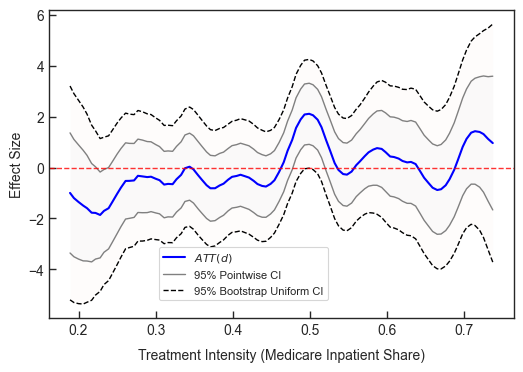

In [75]:
# NOTE: the styles are set to fit the original actual data set. 
# Adjust as needed for simulated dataset for aethetics.

# Set seaborn theme for better aesthetics
sns.set_theme()
#sns.set_theme(style="whitegrid")  # Subtle grid for readability
sns.set_context("paper")  # Paper-friendly settings
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})

# Convert lists to numpy arrays
yk_tech = np.asarray(att_tech)
yl_tech = np.asarray(yl_tech)
yu_tech = np.asarray(yu_tech)
yl_unif_tech = np.asarray(yl_unif_tech)
yu_unif_tech = np.asarray(yu_unif_tech)
xk_tech = dlist #np.linspace(dl, du, len(dlist))

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size for better proportions

# Plot lines
ax.plot(xk_tech, yk_tech, '-', color='blue', markersize=2, linewidth=1.5, label=r'$ATT(d)$')
ax.plot(xk_tech, yl_tech, '-', color='gray', linewidth=1, label='95% Pointwise CI')
ax.plot(xk_tech, yu_tech, '-', color='gray', linewidth=1)
ax.plot(xk_tech, yl_unif_tech, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
ax.plot(xk_tech, yu_unif_tech, '--', color='black', linewidth=1)

# Horizontal reference line at zero
ax.axhline(y=0, color='red', linewidth=1, linestyle='--', alpha=0.8)

# Add shaded confidence bands
ax.fill_between(xk_tech, yl_tech, yu_tech, alpha=0.02)  # Pointwise CI shading
ax.fill_between(xk_tech, yl_unif_tech, yu_unif_tech,alpha=0.02)  # Uniform CB shading

#ax.set_ylim(-3.5, 4.5)

# Labels and title
ax.set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10, labelpad=8)
ax.set_ylabel(r'Effect Size', fontsize=10, labelpad=3)  # Add ylabel for clarity
#ax.set_title(r'ATT($d$): Capital-Labor Ratio, Panel (Average)', fontsize=12, pad=10)

# Adjust tick font size and format
ax.tick_params(axis='both', which='major', labelsize=10)

# Improved legend positioning

ax.legend(fontsize=8, bbox_to_anchor=(0.6, 0.23), borderaxespad=0)


# Save as high-quality PDF (comment out if not needed)
#plt.savefig("cdid_tech_panel_avg_rnr.pdf", bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
##########################################################
## Optional (not in paper) plot positive kernel density ##
##########################################################

Selected undersmoothed bandwidth: 0.0266


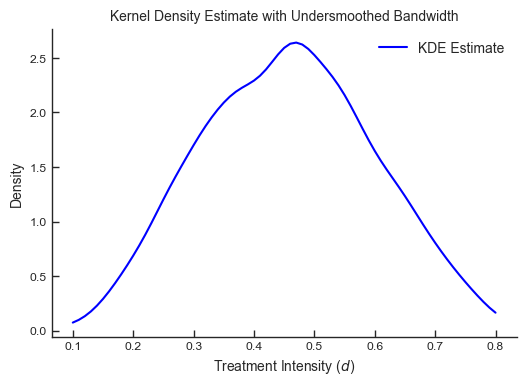

In [76]:
# Set seaborn theme for better aesthetics
sns.set_theme()
sns.set_context("paper")
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})

# Extract positive D values
D_positive = dfcl[dfcl.D > 0].D.to_numpy()

# # Define a range of bandwidths for cross-validation search
bandwidths = np.linspace(0.001, 0.5, 40)

# # Set cross-validation with controlled randomness
cv = KFold(n_splits=5, shuffle=True, random_state=923)

# # Perform GridSearchCV with fixed seed
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=cv)
grid.fit(D_positive[:, None])

# # Retrieve the optimal bandwidth and apply undersmoothing (3/4 factor)
h = np.round(grid.best_params_['bandwidth'], 4)
print(f"Selected undersmoothed bandwidth: {h}")

# Fit KDE with the selected bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(D_positive[:, None])

# Define evaluation points (dlist)
dlist = np.round(np.linspace(0.1, 0.8, 71), 2).tolist()
dlist_arr = np.array(dlist)[:, None]  # Convert to 2D array for KDE input

# Compute KDE estimates
log_dens = kde.score_samples(dlist_arr)
density_values = np.exp(log_dens)  # Convert log-density to actual density

# Plot KDE on dlist
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dlist, density_values, color='blue', linewidth=1.5, label="KDE Estimate")
ax.set_xlabel(r'Treatment Intensity ($d$)', fontsize=10)
ax.set_ylabel(r'Density', fontsize=10)
ax.set_title(r'Kernel Density Estimate with Undersmoothed Bandwidth', fontsize=10)

# Improved legend
ax.legend(fontsize=10, loc='upper right', frameon=False)

# Remove top and right spines for cleaner look
sns.despine()

# Show the plot
plt.show()

In [ ]:
#####################################
# Estimate ATT(d) without covariates
#####################################

In [77]:
def gaussian_kernel(u):
    """ Standard Gaussian kernel function. """
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

def kernel_regression(D, Y, d_eval, h):
    """
    Perform Nadaraya-Watson Kernel Regression: E[Y | D=d]
    
    Parameters:
    D (array-like): Treatment intensity values
    Y (array-like): Outcome differences (ΔY = Y1 - Y0)
    d_eval (array-like): Points where we estimate E[Y | D]
    h (float): Bandwidth for kernel smoothing
    
    Returns:
    array: Estimated E[Y | D=d_eval]
    """
    estimates = []
    for d in d_eval:
        weights = gaussian_kernel((D - d) / h)  # Compute kernel weights
        if np.sum(weights) == 0:
            estimates.append(np.nan)  # Avoid division by zero
        else:
            estimates.append(np.sum(weights * Y) / np.sum(weights))  # Kernel-weighted mean
    return np.array(estimates)

def estimate_ATT_and_CI(D, Y, d_grid, h, B=500, alpha=0.05, wild_type="rademacher"):
    """
    Estimate ATT(d) = E[ΔY | D=d] - E[ΔY | D=0] and compute bootstrap confidence intervals.
    
    Parameters:
    D (array-like): Treatment intensity values.
    Y (array-like): Outcome differences (ΔY = Y1 - Y0).
    d_grid (array-like): Points where ATT(d) is evaluated.
    h (float): Bandwidth for kernel smoothing.
    B (int): Number of bootstrap replications.
    alpha (float): Significance level (default: 0.05 for 95% CI).
    
    Returns:
    tuple: (ATT estimates, lower CI, upper CI)
    """
    N = len(Y)
    
    # Compute E[ΔY | D=d] for D > 0 using kernel regression
    E_Y_given_D_pos = kernel_regression(D[D > 0], Y[D > 0], d_grid, h)
    
    # Compute E[ΔY | D=0] as the empirical mean
    E_Y_given_D0 = np.mean(Y[D == 0])  # Mean of ΔY where D=0
    
    # Compute ATT(d) = E[ΔY | D=d] - E[ΔY | D=0]
    ATT_d = E_Y_given_D_pos - E_Y_given_D0
    
    # Now compute E_Y_given_D_full for each observation:
    E_Y_given_D_full = np.zeros_like(Y)
    
    # For control observations (D==0), assign the empirical mean
    E_Y_given_D_full[D == 0] = E_Y_given_D0
    
    # For treated observations (D>0), compute the kernel regression estimate at the observed D value
    indices_positive = np.where(D > 0)[0]
    for i in indices_positive:
        # Evaluate the kernel regression at the specific D[i] > 0
        # Note: kernel_regression returns an array; take the first (and only) element.
        E_Y_given_D_full[i] = kernel_regression(D[D > 0], Y[D > 0], np.array(D[i]).reshape(-1), h)[0]
    
    # Compute residuals correctly
    residuals = Y - E_Y_given_D_full

    # Compute bootstrap estimates using weighted residuals
    boot_ATT = np.zeros((B, len(d_grid)))
    
    for b in range(B):
        if wild_type == "rademacher":
            W = np.random.choice([-1, 1], size=N)  # Rademacher distribution
        elif wild_type == "mammen":
            nu1, nu2 = (1 - np.sqrt(5)) / 2, (1 + np.sqrt(5)) / 2
            p1, p2 = nu2 / (nu1 + nu2), nu1 / (nu1 + nu2)
            W = np.random.choice([nu1, nu2], size=N, p=[p1, p2])  # Mammen's distribution
        else:
            raise ValueError("Invalid wild bootstrap type. Choose 'rademacher' or 'mammen'.")
            
        boot_Y = E_Y_given_D_full + W * residuals
        boot_ATT[b, :] = kernel_regression(D[D > 0], boot_Y[D > 0], d_grid, h) - np.mean(boot_Y[D == 0])

    # Compute standard error and confidence intervals
    std_err = np.std(boot_ATT, axis=0)
    lower_CI = ATT_d - 1.96 * std_err
    upper_CI = ATT_d + 1.96 * std_err
    
    # compute uniform confidence band
    unif = [
        max(np.abs(ATT_d[i] - boot_ATT[b, i])/std_err[i] for i in range(len(d_grid))) for b in range(B)
    ]
    
    lower_unif_CI = [ATT_d[i] - np.percentile(unif, 95)*std_err[i] for i in range(len(d_grid))]
    upper_unif_CI = [ATT_d[i] + np.percentile(unif, 95)*std_err[i] for i in range(len(d_grid))]

    return ATT_d, lower_CI, upper_CI, lower_unif_CI, upper_unif_CI

In [78]:
##############################
# Data for capital labor ratio
##############################
dY_cl = Y1_cl - Y0_cl  # Outcome difference (ΔY)

# Define grid for ATT estimation
## set model paramters:

D_pos_cl = D_cl[D_cl>0]

dl_cl = np.percentile(D_pos_cl, 2.5)
du_cl = np.percentile(D_pos_cl, 97.5)

dlist = np.round(np.linspace(dl_cl,du_cl,100),3).tolist()

n = len(D_cl)

dlist  # Evaluation points for ATT
h = 1.06*np.std(D_cl[D_cl>0])*n**(-1/4)


# Estimate ATT(d) and compute confidence intervals

att_cl_nc, yl_cl_nc, yu_cl_nc, yl_unif_cl_nc, yu_unif_cl_nc = estimate_ATT_and_CI(D_cl, dY_cl, dlist, h, B=1000, wild_type="rademacher")



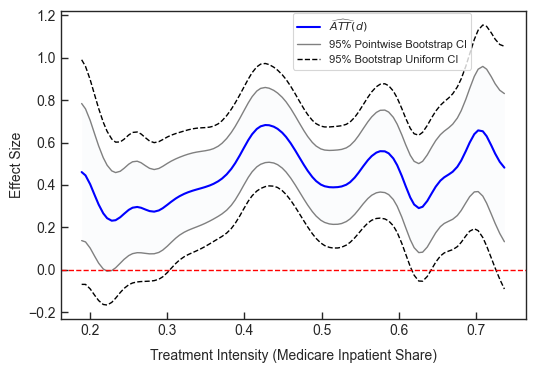

In [89]:
# Plot results

# NOTE: the styles are set to fit the original actual data set. 
# Adjust as needed for simulated dataset for aethetics.

# Set seaborn theme for better aesthetics
sns.set_theme()
#sns.set_theme(style="whitegrid")  # Subtle grid for readability
sns.set_context("paper")  # Paper-friendly settings
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})

fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size for better proportions

ax.plot(dlist, att_cl_nc, '-', label=r'$\widehat{ATT}(d)$', color='blue', linewidth=1.5)
ax.plot(dlist, yl_cl_nc, '-', color = "gray", linewidth = 1, label="95% Pointwise Bootstrap CI")
ax.plot(dlist, yu_cl_nc, '-', color = "gray", linewidth = 1)
ax.plot(dlist, yl_unif_cl_nc, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
ax.plot(dlist, yu_unif_cl_nc, '--', color='black', linewidth=1)

ax.fill_between(dlist, yl_cl_nc, yu_cl_nc, alpha=0.02)
ax.fill_between(dlist, yl_unif_cl_nc, yl_unif_cl_nc, alpha=0.02)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

ax.set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10, labelpad=8)
ax.set_ylabel(r'Effect Size', fontsize=10, labelpad=3)  # Add ylabel for clarity
#ax.set_title(r'ATT($d$): Capital-Labor Ratio, Panel (Average)', fontsize=12, pad=10)

# Adjust tick font size and format
ax.tick_params(axis='both', which='major', labelsize=10)

# Improved legend positioning

ax.legend(fontsize=8, bbox_to_anchor=(0.5, 0.81), borderaxespad=0)

# set y-axis limit for better comparison
#ax.set_ylim(-0.7, 2.2)


# Save as high-quality PDF (comment out if not needed)
# plt.savefig("cdid_cl_panel_avg_rnr.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [80]:
##############################
# Data for tech adoption
##############################

dY_tech = Y1_tech - Y0_tech  # Outcome difference (ΔY)

# Define grid for ATT estimation
## set model paramters:

D_pos_tech = D_tech[D_tech>0]

dl_tech = np.percentile(D_pos_tech, 2.5)
du_tech = np.percentile(D_pos_tech, 97.5)

dlist = np.round(np.linspace(dl_tech,du_tech,100),3).tolist()

n = len(D_tech)

dlist  # Evaluation points for ATT
h = 1.06*np.std(D_tech[D_tech>0])*n**(-1/4)


# Estimate ATT(d) and compute confidence intervals

att_tech_nc, yl_tech_nc, yu_tech_nc, yl_unif_tech_nc, yu_unif_tech_nc = estimate_ATT_and_CI(D_tech, dY_tech, dlist, h, B=1000, wild_type="rademacher")


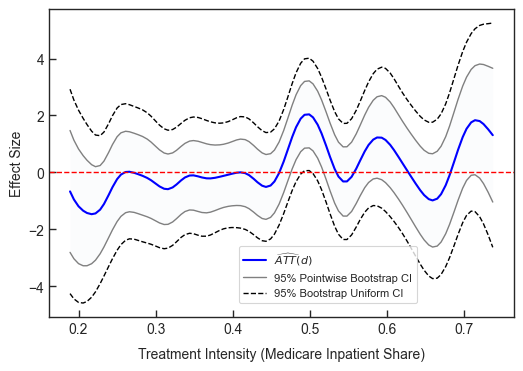

In [90]:
# Plot results

# NOTE: the styles are set to fit the original actual data set. 
# Adjust as needed for simulated dataset for aethetics.

# Set seaborn theme for better aesthetics
sns.set_theme()
#sns.set_theme(style="whitegrid")  # Subtle grid for readability
sns.set_context("paper")  # Paper-friendly settings
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})

fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size for better proportions

ax.plot(dlist, att_tech_nc, '-', label=r'$\widehat{ATT}(d)$', color='blue', linewidth=1.5)
ax.plot(dlist, yl_tech_nc, '-', color = "gray", linewidth = 1, label="95% Pointwise Bootstrap CI")
ax.plot(dlist, yu_tech_nc, '-', color = "gray", linewidth = 1)
ax.plot(dlist, yl_unif_tech_nc, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
ax.plot(dlist, yu_unif_tech_nc, '--', color='black', linewidth=1)

ax.fill_between(dlist, yl_tech_nc, yu_tech_nc, alpha=0.02)
ax.fill_between(dlist, yl_unif_tech_nc, yl_unif_tech_nc, alpha=0.02)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

ax.set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10, labelpad=8)
ax.set_ylabel(r'Effect Size', fontsize=10, labelpad=3)  # Add ylabel for clarity
#ax.set_title(r'ATT($d$): Capital-Labor Ratio, Panel (Average)', fontsize=12, pad=10)

# Adjust tick font size and format
ax.tick_params(axis='both', which='major', labelsize=10)

# Improved legend positioning

ax.legend(fontsize=8, bbox_to_anchor=(0.6, 0.23), borderaxespad=0)

# set y-axis limit for better comparison
#ax.set_ylim(-3, 4.5)


# Save as high-quality PDF (comment out if not needed)
# plt.savefig("cdid_tech_panel_avg_rnr.pdf", bbox_inches='tight', dpi=300)
plt.show()

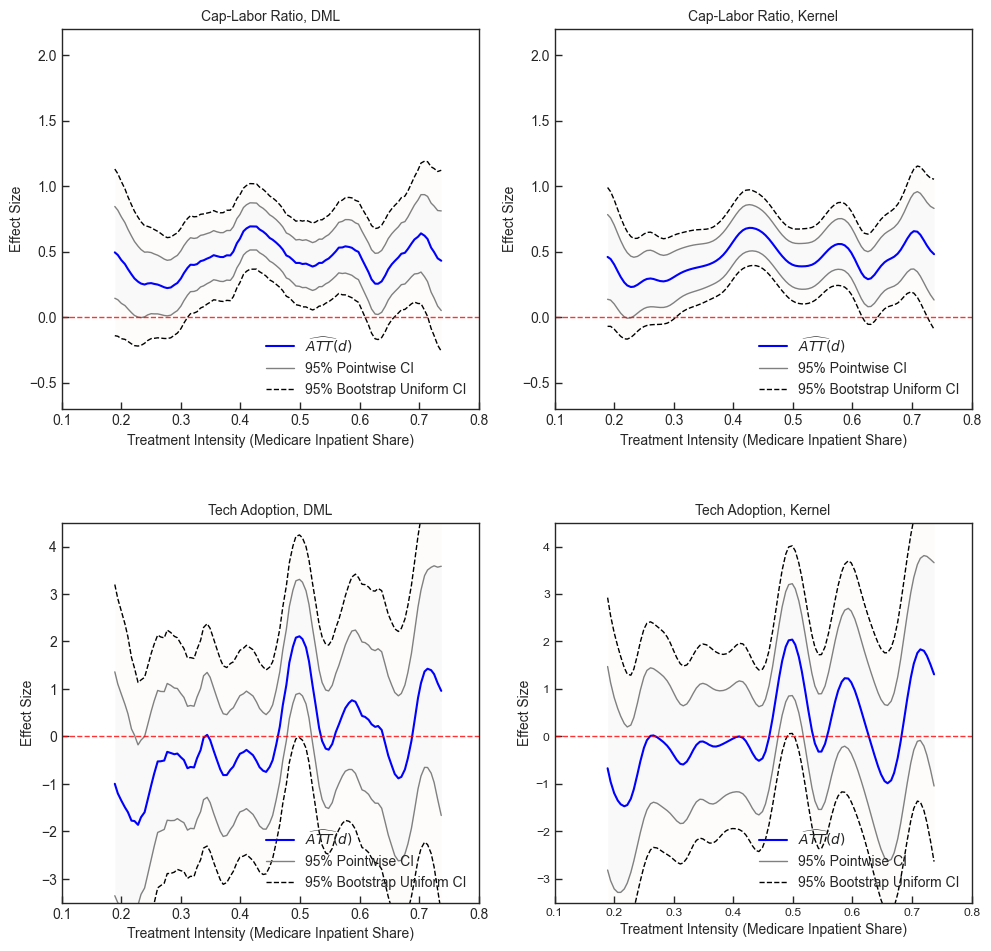

In [91]:
## Plot all results together

# NOTE: the styles are set to fit the original actual data set. 
# Adjust as needed for simulated dataset for aethetics.

fig, axs = plt.subplots(2, 2, figsize=(10, 10))


# Determine the common x-axis range
xmin = 0.1
xmax = 0.8

## top (0,0) figure, cap-labor ratio, dmlcdid

axs[0,0].plot(xk_cl, yk_cl, '-', color='blue', markersize=2, linewidth=1.5, label=r'$\widehat{ATT}(d)$')
axs[0,0].plot(xk_cl, yl_cl, '-', color='gray', linewidth=1, label='95% Pointwise CI')
axs[0,0].plot(xk_cl, yu_cl, '-', color='gray', linewidth=1)
axs[0,0].plot(xk_cl, yl_unif_cl, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
axs[0,0].plot(xk_cl, yu_unif_cl, '--', color='black', linewidth=1)
axs[0,0].axhline(y=0, color='red', linewidth=1, linestyle='--', alpha=0.8)
axs[0,0].fill_between(xk_cl, yl_cl, yu_cl, alpha=0.02)  # Pointwise CI shading
axs[0,0].fill_between(xk_cl, yl_unif_cl, yu_unif_cl,alpha=0.02)  # Uniform CB shading
axs[0,0].set_title('Cap-Labor Ratio, DML', fontsize = 10)
axs[0,0].set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10)
axs[0,0].set_ylabel(r'Effect Size', fontsize=10)  # Add ylabel for clarity
axs[0,0].tick_params(axis='both', which='major', labelsize=10)
axs[0,0].set_xlim(xmin, xmax)
axs[0,0].set_ylim(-0.7, 2.2)
axs[0,0].legend(fontsize=10, loc='lower right', bbox_to_anchor=(1,0), frameon=False)


## top (0,1) figure, cap-labor ratio, no covariates

axs[0,1].plot(xk_cl, att_cl_nc, '-', color='blue', markersize=2, linewidth=1.5, label=r'$\widehat{ATT}(d)$')
axs[0,1].plot(xk_cl, yl_cl_nc, '-', color='gray', linewidth=1, label='95% Pointwise CI')
axs[0,1].plot(xk_cl, yu_cl_nc, '-', color='gray', linewidth=1)
axs[0,1].plot(xk_cl, yl_unif_cl_nc, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
axs[0,1].plot(xk_cl, yu_unif_cl_nc, '--', color='black', linewidth=1)
axs[0,1].axhline(y=0, color='red', linewidth=1, linestyle='--', alpha=0.8)
axs[0,1].fill_between(xk_cl, yl_cl_nc, yu_cl_nc, alpha=0.02)  # Pointwise CI shading
axs[0,1].fill_between(xk_cl, yl_unif_cl_nc, yu_unif_cl_nc,alpha=0.02)  # Uniform CB shading
axs[0,1].set_title('Cap-Labor Ratio, Kernel', fontsize = 10)
axs[0,1].set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10)
axs[0,1].set_ylabel(r'Effect Size', fontsize=10)  # Add ylabel for clarity
axs[0,1].tick_params(axis='both', which='major', labelsize=10)
axs[0,1].set_xlim(xmin, xmax)
axs[0,1].set_ylim(-0.7, 2.2)
axs[0,1].legend(fontsize=10, loc='lower right', bbox_to_anchor=(1,0), frameon=False)


## bottom (1,0) figure, tech, dmlcdid

axs[1,0].plot(xk_tech, yk_tech, '-', color='blue', markersize=2, linewidth=1.5, label=r'$\widehat{ATT}(d)$')
axs[1,0].plot(xk_tech, yl_tech, '-', color='gray', linewidth=1, label='95% Pointwise CI')
axs[1,0].plot(xk_tech, yu_tech, '-', color='gray', linewidth=1)
axs[1,0].plot(xk_tech, yl_unif_tech, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
axs[1,0].plot(xk_tech, yu_unif_tech, '--', color='black', linewidth=1)
axs[1,0].axhline(y=0, color='red', linewidth=1, linestyle='--', alpha=0.8)
axs[1,0].fill_between(xk_tech, yl_tech, yu_tech, alpha=0.02)  # Pointwise CI shading
axs[1,0].fill_between(xk_tech, yl_unif_tech, yu_unif_tech,alpha=0.02)  # Uniform CB shading
axs[1,0].set_title('Tech Adoption, DML', fontsize = 10)
axs[1,0].set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10)
axs[1,0].set_ylabel(r'Effect Size', fontsize=10)  # Add ylabel for clarity
axs[1,0].tick_params(axis='both', which='major', labelsize=10)
axs[1,0].set_xlim(xmin, xmax)
axs[1,0].set_ylim(-3.5, 4.5)
axs[1,0].legend(fontsize=10, loc='lower right', bbox_to_anchor=(1,0), frameon=False)

## bottom (1,1) figure, tech, no covariates

axs[1,1].plot(xk_tech, att_tech_nc, '-', color='blue', markersize=2, linewidth=1.5, label=r'$\widehat{ATT}(d)$')
axs[1,1].plot(xk_tech, yl_tech_nc, '-', color='gray', linewidth=1, label='95% Pointwise CI')
axs[1,1].plot(xk_tech, yu_tech_nc, '-', color='gray', linewidth=1)
axs[1,1].plot(xk_tech, yl_unif_tech_nc, '--', color='black', linewidth=1, label='95% Bootstrap Uniform CI')
axs[1,1].plot(xk_tech, yu_unif_tech_nc, '--', color='black', linewidth=1)
axs[1,1].axhline(y=0, color='red', linewidth=1, linestyle='--', alpha=0.8)
axs[1,1].fill_between(xk_tech, yl_tech_nc, yu_tech_nc, alpha=0.02)  # Pointwise CI shading
axs[1,1].fill_between(xk_tech, yl_unif_tech_nc, yu_unif_tech_nc,alpha=0.02)  # Uniform CB shading
axs[1,1].set_title('Tech Adoption, Kernel', fontsize = 10)
axs[1,1].set_xlabel(r'Treatment Intensity (Medicare Inpatient Share)', fontsize=10)
axs[1,1].set_ylabel(r'Effect Size', fontsize=10, labelpad=3)  # Add ylabel for clarity
axs[1,1].tick_params(axis='both', which='major')
axs[1,1].set_xlim(xmin, xmax)
axs[1,1].set_ylim(-3.5, 4.5)
axs[1,1].legend(fontsize=10, loc='lower right', bbox_to_anchor=(1,0), frameon=False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect to make room for the suptitle
plt.subplots_adjust(hspace=0.3)  # Increase the vertical space between subplots

# Save the figure in high resolution
# plt.savefig('dmlcdid_all.png', dpi=300)

plt.show()